## load packages

In [75]:
from sklearn.metrics import confusion_matrix
import load_data
import my_metrics
import plot_learning_curve
import numpy as np
import sys 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
import pandas as pd
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib as mpl

%matplotlib inline

In [76]:
lev_name = [117,138,162,191,226,268,316,374,441,521,607,689,761,819,858,886,912,936,957,976,993]

In [81]:
#dilute_cape = np.loadtxt("../../data/goamazon/dilute_cape")
#dilute_dcape = np.loadtxt("../../data/goamazon/dilute_dcape")
#undilute_dcape = np.loadtxt("../../data/goamazon/undilute_dcape")
#undilute_cape = np.loadtxt("../../data/goamazon/undilute_cape")
#undilute_cape = np.loadtxt("/global/homes/z/zhangtao/tmp/goamazon_dc.txt")
#undilute_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_dilute_dcape.txt")

dilute_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_dilute_cape_tiedke_0.5.txt")
dilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_dilute_dcape_tiedke_0.5.txt")
undilute_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_undilute_cape_tiedke_0.5.txt")
undilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_undilute_dcape_tiedke_0.5.txt")

#dilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_dilute_dcape_2.txt")
#undilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/goamazon_undilute_dcape_2.txt")

lcl = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/ML/data//goamazon_dilute_lcl")

dataset = load_data.load_arm_hy("/global/homes/z/zhangtao/ML_trigger/ML/data/trigger_goamazon_hy.nc")

dataset['cape'] = dilute_dcape
dataset['lcl'] = lcl
print(dataset.shape)

dataset.rename(columns={'cape': 'ddcape'}, inplace=True)

pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]
print(pos.shape)
print(neg.shape)

trig_x = dataset.iloc[:,0:86]
trig_y = dataset.iloc[:,86]

print(np.sum(trig_y))
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)



(5840, 92)
(935, 92)
(4905, 92)
935.0


nan


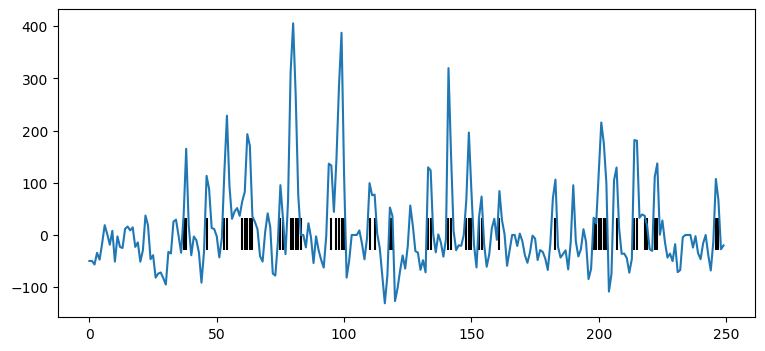

In [20]:
real_trigger = np.zeros(5840)
for i in range(5840):
    if dataset.loc[i,'PRECT'] > 0.5:
        real_trigger[i] = 1
    else:
        real_trigger[i] = np.nan

print(sum(real_trigger))
fig, ax = plt.subplots(1,1,figsize=(9,4))
ax.scatter(range(250),real_trigger[:250],color='k', marker='|',s=500)
ax.plot(range(250), dataset.loc[:250-1,'ddcape'])

### xgboost

In [254]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)

f1_scores = cross_val_score(xgb, trig_x, trig_y, cv=cv, scoring="f1_macro")
print(f1_scores)
print(f1_scores.mean())

[0.89176165 0.89359456 0.89449146 0.89448788 0.88464868]
0.8917968458572549


In [59]:
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)
xgb.fit(trig_x_train,trig_y_train)
trig_y_pred = xgb.predict(trig_x_test)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
p  = precision_score(trig_y_test, trig_y_pred,average='macro')
r  = recall_score(trig_y_test, trig_y_pred,average='macro')

print(tp, fp, fn, tn)
print(f1, p, r)

171 22 26 949
0.9261285477112816 0.929671848013817 0.9226816249928118


In [84]:
cape_trigger = np.zeros(trig_y_test.shape)

#print(trig_x_test)

for i in range(len(trig_y_test)):
    if trig_x_test.iloc[i,4] > 37:
        cape_trigger[i] = 1

tn, fp, fn, tp = confusion_matrix(trig_y_test, cape_trigger).ravel()
f1 = f1_score(trig_y_test, cape_trigger,average='macro')
p  = precision_score(trig_y_test, cape_trigger,average='macro')
r  = recall_score(trig_y_test, cape_trigger,average='macro')

print(tp,fp,fn,tn)
print(f1, p, r)

159 27 38 944
0.8985025381049974 0.9080710859996058 0.8896501069074219


|          | TP  | FP  | FN  | TN  |  F1  |  P   |  R   |
|----------|-----|-----|-----|-----|------|------|------|
|XGboost   | 136 |18   | 61  | 953 |0.868 |0.911 | 0.836|
|dd(0)     | 144 |149  | 53  | 822 |0.739 |0.715 | 0.789|
|dd(65)    | 93  |2    | 104 | 969 |0.793 |0.941 |0.735 |
|dc        | 26  |63   | 171 | 908 |0.534 |0.567 |0.534 |
|udd(0)    | 120 |196  | 77  | 775 |0.659 |0.645 |0.704 |
|udd(65)   | 71  |11   | 126 | 960 |0.721 |0.875 |0.675 |
|udc       | 46  |344  | 151 | 627 |0.437 |0.462 |0.440 |

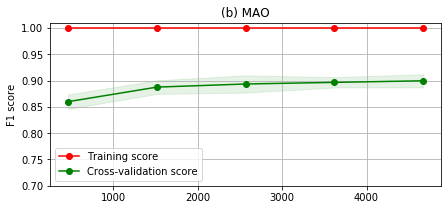

In [7]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
title = "(b) MAO"
g = plot_learning_curve.plot_learning_curve(xgb,title,trig_x, trig_y,ylim=(0.7, 1.01), cv=cv, n_jobs=8)
plt.xlabel("")
plt.savefig("figs/goamazon_robust_sample.pdf")

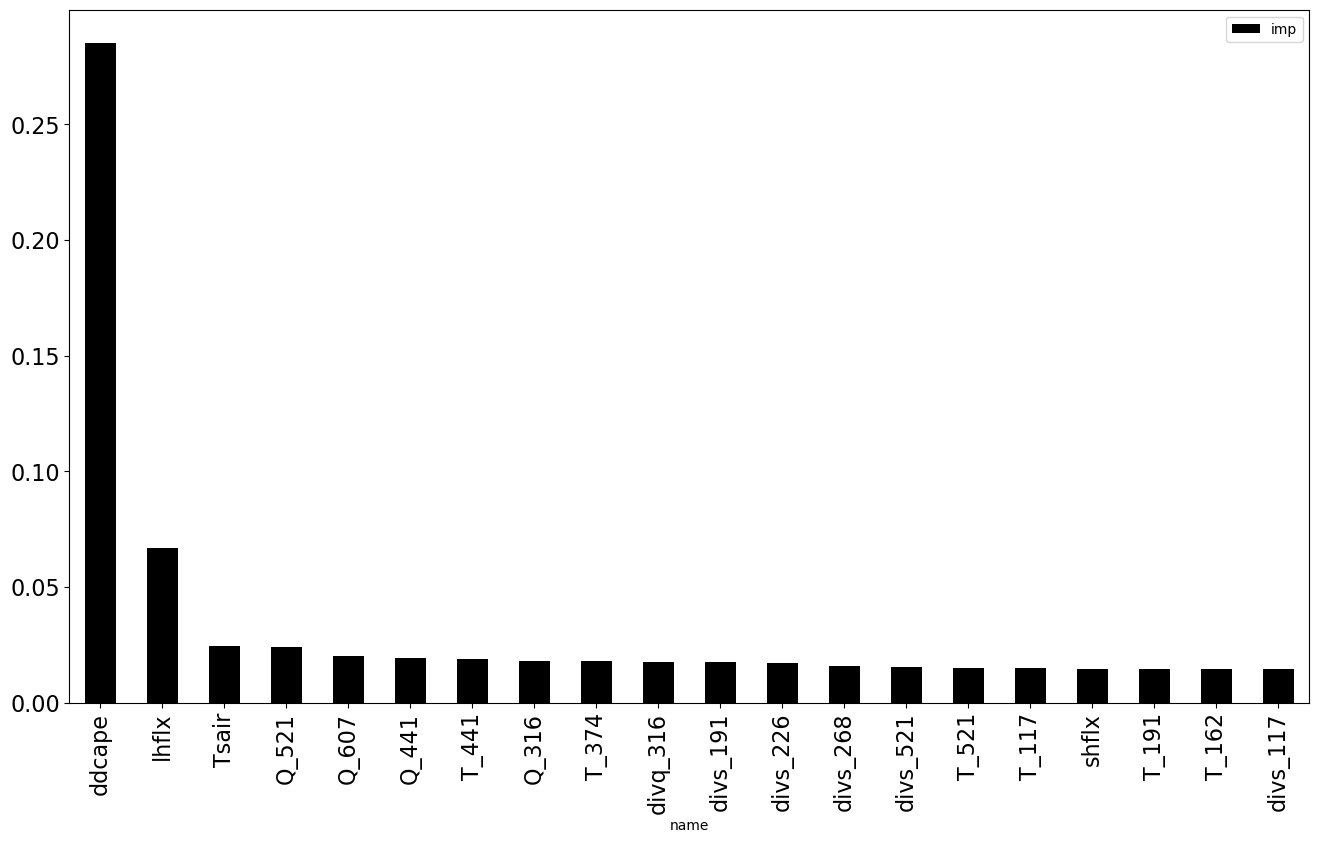

In [56]:
importance = xgb.feature_importances_
name = dataset.columns.values.tolist()
imp_df = pd.DataFrame(importance,columns=['imp'])
imp_df['name'] = name[0:86]
imp_df.set_index('name',inplace=True)
imp_df.sort_values('imp',inplace=True,ascending=False)
#print(imp_df)
imp_df.iloc[:20].plot.bar(figsize=(16,9), color='k',fontsize=16)
#plt.savefig("figs/goamazon_imp.pdf")

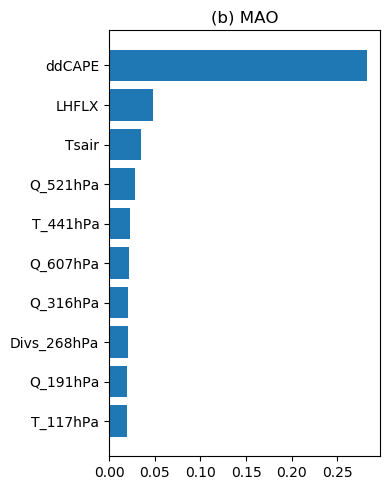

In [263]:
imp_data = imp_df.iloc[:10].values.reshape(-1)
var_name = ['ddCAPE','LHFLX','Tsair','Q_521hPa','T_441hPa','Q_607hPa','Q_316hPa','Divs_268hPa','Q_191hPa','T_117hPa']
pos = np.arange(len(var_name))

fig, ax = plt.subplots(figsize=(4,5))
ax.invert_yaxis()
ax.barh(var_name,imp_data, color="tab:blue")
ax.set_title("(b) MAO")
plt.tight_layout()
plt.savefig("figs/goamazon_imp.pdf")

['fast', 'seaborn-white', 'seaborn-ticks', 'bmh', 'seaborn-paper', 'dark_background', 'seaborn-pastel', 'seaborn-dark', 'grayscale', 'seaborn-notebook', 'tableau-colorblind10', 'ggplot', 'seaborn-deep', '_classic_test', 'fivethirtyeight', 'seaborn-dark-palette', 'seaborn', 'classic', 'seaborn-muted', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-darkgrid', 'seaborn-whitegrid', 'seaborn-talk', 'Solarize_Light2', 'seaborn-poster']


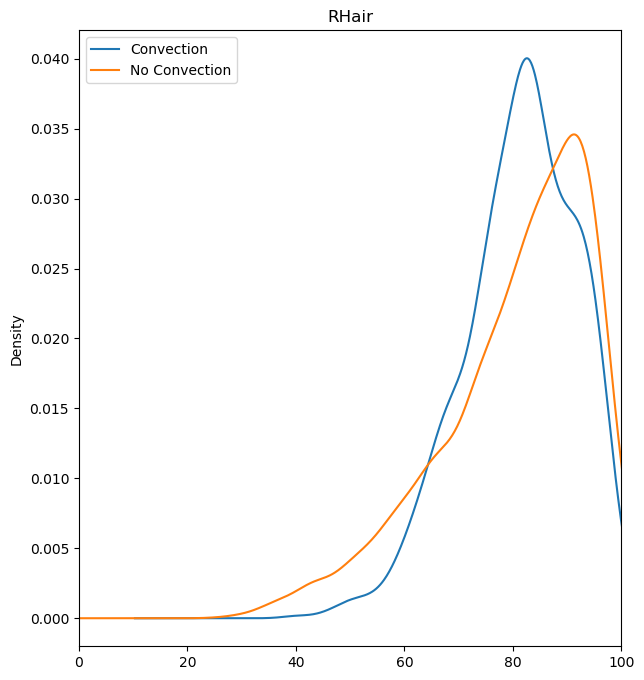

In [19]:
print(plt.style.available)

def single_factor_diag(pos, neg, name, figname):
    fac_pos = pos[name]
    fac_neg = neg[name]
    box_data = pd.concat([fac_pos, fac_neg], axis=1)
    box_data.columns = ['Convection', 'No Convection']
    #box_data.boxplot(grid=False)
    box_data.plot.kde(figsize=(7,8))
    plt.title(name)
    plt.xlim(0,100)
    plt.savefig("figs/goamazon_RHair_hist.pdf")
    #plt.savefig(figname)

plt.style.use('default')
single_factor_diag(pos, neg, 'RHair', 'RHair_hist')


In [68]:
sl = trig_x.shape[0]
train_len = int(sl * 3 / 4)
ts_x_train = trig_x.iloc[:train_len,:]
ts_y_train = trig_y.iloc[:train_len]
ts_x_test  = trig_x.iloc[train_len:,:]
ts_y_test  = trig_y.iloc[train_len:].tolist()
prect_test = dataset['PRECT'].iloc[train_len:]
hour_test  = dataset['hour'].iloc[train_len:]
day_test  = dataset['day'].iloc[train_len:]
mon_test  = dataset['mon'].iloc[train_len:]
year_test = dataset['year'].iloc[train_len:]

#print(year_test)
#print(mon_test)
#print(day_test)
#print(hour_test)
xgb.fit(ts_x_train, ts_y_train)
ts_y_pred = xgb.predict(ts_x_test)

print(ts_x_test.shape)

for i in range(ts_x_test.shape[0]):
    if ts_y_pred[i] == 0:
        ts_y_pred[i] = np.nan
    if ts_y_test[i] == 0:
        ts_y_test[i] = np.nan

(1460, 86)


In [69]:
print(train_len)

4380


In [70]:
#dilute_cape = np.loadtxt("../../data/goamazon/goamazon_dilute_cape.txt")
#dilute_dcape = np.loadtxt("../../data/goamazon/goamazon_dilute_dcape.txt")
#undilute_dcape = np.loadtxt("../../data/goamazon/goamazom_undilute_dcape.txt")
#undilute_cape = np.loadtxt("../../data/goamazon/goamazom_undilute_cape.txt")


dilute_cape_test = dilute_cape[train_len:]
dilute_dcape_test = dilute_dcape[train_len:]
undilute_dcape_test = undilute_dcape[train_len:]
undilute_cape_test = undilute_cape[train_len:]

dilute_cape_pred = np.zeros(ts_y_pred.shape)
dilute_dcape_pred = np.zeros(ts_y_pred.shape)
undilute_dcape_pred = np.zeros(ts_y_pred.shape)
undilute_cape_pred = np.zeros(ts_y_pred.shape)


for i in range(len(ts_y_pred)):
    if dilute_cape_test[i] > 70:
        dilute_cape_pred[i] = 1
    else:
        dilute_cape_pred[i] = np.nan
        
    if dilute_dcape_test[i] > 65:
        dilute_dcape_pred[i] = 1
    else:
        dilute_dcape_pred[i] = np.nan
        
    if undilute_dcape_test[i] > 65:
        undilute_dcape_pred[i] = 1
    else:
        undilute_dcape_pred[i] = np.nan
        
    if undilute_cape_test[i] > 70:
        undilute_cape_pred[i] = 1
    else:
        undilute_cape_pred[i] = np.nan

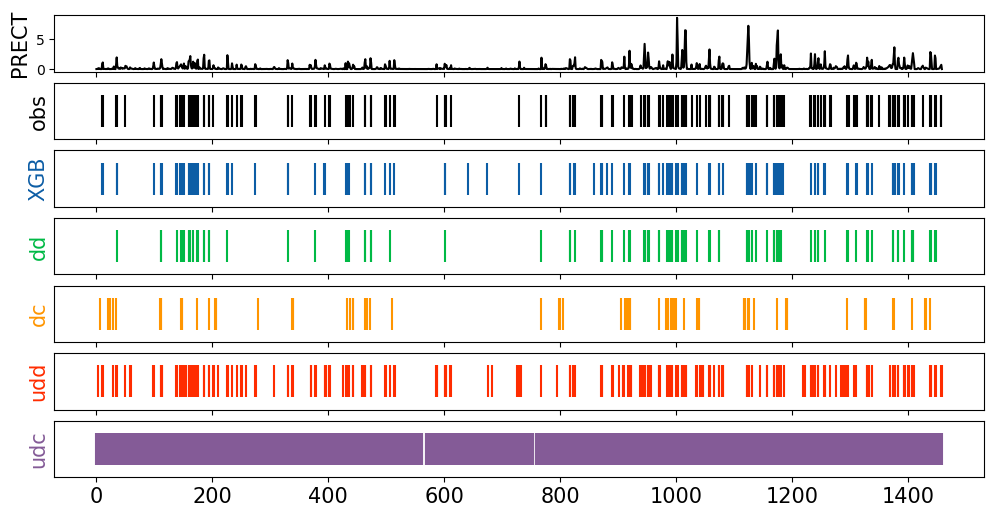

In [71]:
plt.style.use('default')
colors=['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

fig, axes = plt.subplots(nrows=7, ncols=1, sharex=True, figsize=(12,6))
trig_idx = range(len(ts_y_pred))

fh = 15
axes[0].plot(prect_test.values.tolist(), color='k')
axes[0].set_ylabel('PRECT',fontsize=fh)
axes[1].scatter(trig_idx,ts_y_test,color='k', marker='|',s=500)
axes[1].set_ylabel('obs',fontsize=fh)
axes[1].set_yticks([])
axes[2].scatter(trig_idx,ts_y_pred,color=colors[0], marker='|',s=500)
axes[2].set_ylabel('XGB',color=colors[0],fontsize=fh)
axes[2].set_yticks([])
axes[3].scatter(trig_idx,dilute_dcape_pred,color=colors[1], marker='|',s=500)
axes[3].set_ylabel('dd',color=colors[1],fontsize=fh)
axes[3].set_yticks([])
axes[4].scatter(trig_idx,dilute_cape_pred, color=colors[2], marker='|',s=500)
axes[4].set_ylabel('dc',color=colors[2],fontsize=fh)
axes[4].set_yticks([])
axes[5].scatter(trig_idx,undilute_dcape_pred,color=colors[3], marker='|',s=500)
axes[5].set_ylabel('udd',color=colors[3],fontsize=fh)
axes[5].set_yticks([])
axes[6].scatter(trig_idx,undilute_cape_pred,color=colors[4], marker='|',s=500)
axes[6].set_ylabel('udc',color=colors[4],fontsize=fh)
axes[6].set_yticks([])

plt.tick_params(labelsize=fh)

plt.savefig("figs/goamazon_ts.pdf")

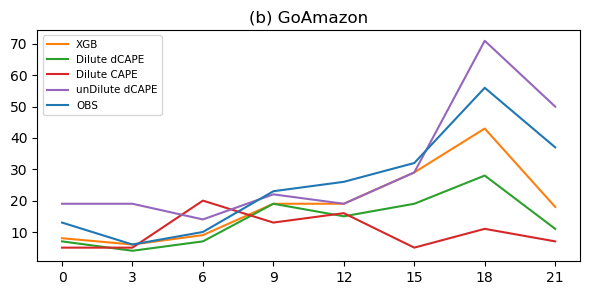

In [72]:
diurnal_prect = np.zeros(24)
diurnal_obs  = np.zeros(24)
diurnal_xgboost  = np.zeros(24)
diurnal_dd  = np.zeros(24)
diurnal_dc  = np.zeros(24)
diurnal_udd  = np.zeros(24)
diurnal_udc  = np.zeros(24)
diurnal_obs  = np.zeros(24)

prect_df = pd.concat([prect_test, hour_test], axis=1)
xgboost_df  = pd.DataFrame({"pred":ts_y_pred, "hour":hour_test})
dd_df = pd.DataFrame({"pred":dilute_dcape_pred, "hour":hour_test})
dc_df = pd.DataFrame({"pred":dilute_cape_pred, "hour":hour_test})
udd_df = pd.DataFrame({"pred":undilute_dcape_pred, "hour":hour_test})
udc_df = pd.DataFrame({"pred":undilute_cape_pred, "hour":hour_test})
obs_df = pd.DataFrame({"pred":ts_y_test, "hour":hour_test})

#for i in [0,3,6,9,12,15,18,21]:
#    diurnal_prect[i] = prect_df[prect_df.hour == i].mean().PRECT
#    diurnal_xgboost[i]  = xgboost_df[xgboost_df.hour == i].mean().pred
#    diurnal_dd[i]  = dd_df[dd_df.hour == i].mean().pred
#    diurnal_dc[i]  = dc_df[dc_df.hour == i].mean().pred
#    diurnal_udd[i]  = udd_df[udd_df.hour == i].mean().pred
#    diurnal_udc[i]  = udc_df[udc_df.hour == i].mean().pred
#    diurnal_obs[i]  = obs_df[obs_df.hour == i].mean().pred
    
    
for i in [0,3,6,9,12,15,18,21]:
    diurnal_prect[i] = prect_df[prect_df.hour == i].sum().PRECT
    diurnal_xgboost[i]  = xgboost_df[xgboost_df.hour == i].sum().pred
    diurnal_dd[i]  = dd_df[dd_df.hour == i].sum().pred
    diurnal_dc[i]  = dc_df[dc_df.hour == i].sum().pred
    diurnal_udd[i]  = udd_df[udd_df.hour == i].sum().pred
    diurnal_udc[i]  = udc_df[udc_df.hour == i].sum().pred
    diurnal_obs[i]  = obs_df[obs_df.hour == i].sum().pred


    
dilurnal_df = pd.DataFrame({"obs":diurnal_obs,"xgboost":diurnal_xgboost, "dilute_dcape":diurnal_dd,"dilute_cape":diurnal_dc
                           ,"undilute_dcape":diurnal_udd})#"undilute_dcape":diurnal_udd, "undilute_cape":diurnal_udc})


#print(dilurnal_df)
#dilurnal_df[dilurnal_df.obs!=0].plot(figsize=(9,3))

diurnal_prect[diurnal_prect==0] = np.nan
s1mask = np.isfinite(diurnal_prect)
#print(diurnal_prect)

#xs = np.arange(24)
#plt.plot(xs[s1mask], diurnal_prect[s1mask], 'ro-', label="PRECT")
#plt.legend(loc = 'upper left',fontsize=8)


fig, ax1 = plt.subplots(figsize=(7,3))
#ax2 = ax1.twinx()
xs = np.arange(24)
ax1.plot(xs[s1mask],diurnal_xgboost[s1mask], color="tab:orange", label="XGB")
ax1.plot(xs[s1mask],diurnal_dd[s1mask], color="tab:green", label="Dilute dCAPE")
ax1.plot(xs[s1mask],diurnal_dc[s1mask], color="tab:red", label="Dilute CAPE")
ax1.plot(xs[s1mask],diurnal_udd[s1mask],color='tab:purple', label="unDilute dCAPE")
ax1.plot(xs[s1mask],diurnal_obs[s1mask], color="tab:blue", label="OBS")

ax1.xaxis.set_ticks(np.arange(0, 24,3)) 

#ax2.plot(xs[s1mask], diurnal_prect[s1mask], '-.', color="tab:blue")
#ax1.plot(np.nan, 'o-', color="tab:blue", label='PRECT')
plt.title("(b) GoAmazon")

ax1.legend(fontsize=7.5)
plt.savefig("figs/goamazon_dilurnal.pdf")

In [73]:
lst_time = np.arange(24) - 4
lst_time[lst_time < 0] += 24

print(lst_time)
print(diurnal_xgboost)

[20 21 22 23  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 8.  0.  0.  6.  0.  0.  9.  0.  0. 19.  0.  0. 19.  0.  0. 29.  0.  0.
 43.  0.  0. 18.  0.  0.]


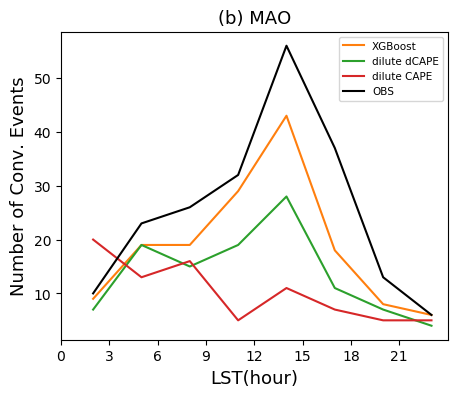

In [74]:
lst_time = np.arange(24) - 4
lst_time[lst_time < 0] += 24

diurnal_xgboost_lst  = np.zeros(24)
diurnal_dd_lst = np.zeros(24)
diurnal_dc_lst = np.zeros(24)
diurnal_obs_lst = np.zeros(24)
diurnal_udd_lst = np.zeros(24)

for i in range(24):
    diurnal_xgboost_lst[lst_time[i]] = diurnal_xgboost[i]
    diurnal_dd_lst[lst_time[i]] = diurnal_dd[i]
    diurnal_dc_lst[lst_time[i]] = diurnal_dc[i]
    diurnal_obs_lst[lst_time[i]] = diurnal_obs[i]
    diurnal_udd_lst[lst_time[i]] = diurnal_udd[i]
    
    
xs = np.arange(24)
diurnal_xgboost_lst[diurnal_xgboost_lst == 0] = np.nan
s1mask = np.isfinite(diurnal_xgboost_lst)
    
fig, ax1 = plt.subplots(figsize=(5,4))
ax1.plot(xs[s1mask],diurnal_xgboost_lst[s1mask], color="tab:orange", label="XGBoost")
ax1.plot(xs[s1mask],diurnal_dd_lst[s1mask], color="tab:green", label="dilute dCAPE")
ax1.plot(xs[s1mask],diurnal_dc_lst[s1mask], color="tab:red", label="dilute CAPE")
#ax1.plot(xs[s1mask],diurnal_udd_lst[s1mask],color='tab:purple', label="undilute dCAPE")
ax1.plot(xs[s1mask],diurnal_obs_lst[s1mask], color="black", label="OBS")
ax1.xaxis.set_ticks(np.arange(0, 24,3)) 
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)

fh=13
ax1.legend(fontsize=7.5)
plt.title("(b) MAO", fontsize=fh)
plt.xlabel("LST(hour)", fontsize=fh)
plt.ylabel("Number of Conv. Events",fontsize=fh)
plt.savefig("figs/goamazon_dilurnal.pdf")

### dt

In [79]:
from sklearn import tree
trig_x=dataset[['ddcape','lhflx','Tsair']]
#trig_x=dataset[['cape']]
print(trig_x.shape)

trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
dt = tree.DecisionTreeClassifier(max_depth=3)

dt.fit(trig_x_train,trig_y_train)
trig_y_pred = dt.predict(trig_x_test)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
p  = precision_score(trig_y_test, trig_y_pred,average='macro')
r  = recall_score(trig_y_test, trig_y_pred,average='macro')
print(tp,fp,fn,tn)
print(f1,p,r)

(5840, 3)
155 14 42 957
0.9092840697900197 0.9375588606357836 0.8861919524065933


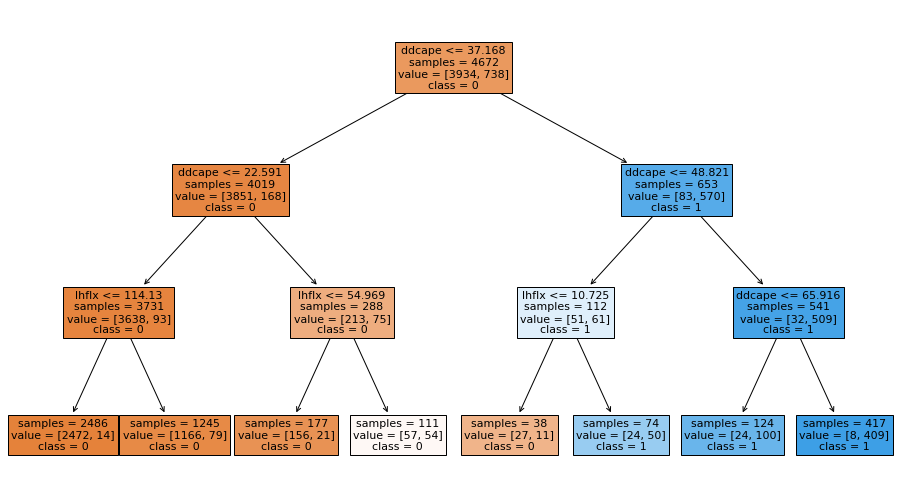

In [80]:
plt.figure(figsize=(16,9))
tree.plot_tree(dt.fit(trig_x_train,trig_y_train), proportion=False, impurity=False,filled=True, feature_names=trig_x.columns, label='all', fontsize=11, class_names=['0','1'])
plt.savefig("figs/MAO_dt.pdf")

445
116 1 3 603
0.9898725311668302 0.9932512482017433 0.9865671434136569


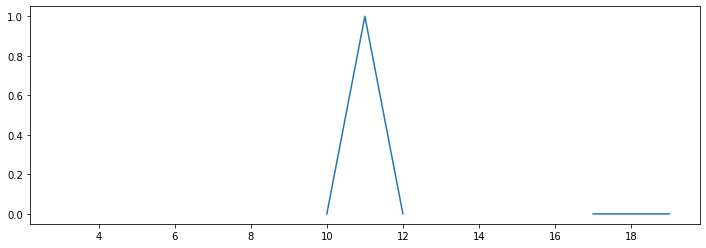

In [85]:
plt.figure(figsize=(12,4))

trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)
cape_trigger = np.zeros(trig_y_test.shape)

#print(trig_x_test)
j = 0
for i in range(len(trig_y_test)):
    if trig_x_test.iloc[i,4] > 66:
        cape_trigger[i] = 1
    elif trig_x_test.iloc[i,4] < 23 and trig_x_test.iloc[i,trig_x_test.columns.get_loc('lhflx')] < 114:
        cape_trigger[i] = 0
    else:
        cape_trigger[i] = np.nan
        j = j + 1
        
print(j)

plt.plot(cape_trigger[:20])

perf = pd.DataFrame({"real":trig_y_test, "pred":cape_trigger})
perf = perf.dropna()




tn, fp, fn, tp = confusion_matrix(perf.loc[:,"real"], perf.loc[:,"pred"]).ravel()
f1 = f1_score(perf.loc[:,"real"], perf.loc[:,"pred"],average='macro')
p  = precision_score(perf.loc[:,"real"], perf.loc[:,"pred"],average='macro')
r  = recall_score(perf.loc[:,"real"], perf.loc[:,"pred"],average='macro')

print(tp,fp,fn,tn)
print(f1,p,r)

In [31]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)
cape_trigger = np.zeros(trig_y_test.shape)

#print(trig_x_test)
j = 0
for i in range(len(trig_y_test)):
    if trig_x_test.iloc[i,4] > 16 and trig_x_test.iloc[i,4] > 37 and  trig_x_test.iloc[i,trig_x_test.columns.get_loc('lhflx')] > 132:
        cape_trigger[i] = 0
    #elif trig_x_test.iloc[i,4] < 11 and trig_x_test.iloc[i,trig_x_test.columns.get_loc('lhflx')] < 142:
    else:
        cape_trigger[i] = np.nan


print(cape_trigger)
print(sum(cape_trigger))
perf = pd.DataFrame({"real":trig_y_test, "pred":cape_trigger})
perf = perf.dropna()
print(perf.sum())



[nan nan nan ... nan nan nan]
nan
real    59.0
pred     0.0
dtype: float64


## joint model

### load date

In [20]:
amazon = load_data.load_arm_hy("../../data/goamazon/trigger_goamazon_hy.nc")
cape_amazon = np.loadtxt("../../data/goamazon/goamazom_undilute_dcape.txt")
lcl_amazon = np.loadtxt("../../data/goamazon/goamazom_undilute_lcl.txt")
amazon['cape'] = cape_amazon
amazon['lcl'] = lcl_amazon
amazon['where'] = 0.0

pos_amazon = amazon[amazon.label==1]
neg_amazon = amazon[amazon.label==0]
print(pos_amazon.shape)
print(neg_amazon.shape)

x_amazon = amazon.iloc[:,0:86]
y_amazon = amazon.iloc[:,86]
x_train_amazon,x_test_amazon,y_train_amazon,y_test_amazon= train_test_split(x_amazon, y_amazon, test_size=0.2, random_state=20)

#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
#xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7,scale_pos_weight=3.5)
#f1_scores = cross_val_score(xgb, x_amazon, y_amazon, cv=cv, scoring="f1_macro")
#print(f1_scores)
#print(f1_scores.mean())

(935, 90)
(4905, 90)


In [21]:
sgp = load_data.load_sgp_data("trigger_sgp_hy.nc")
cape_sgp = np.loadtxt("../../data/sgp/sgp_undilute_cape.txt")
lcl_sgp = np.loadtxt("../../data/sgp/sgp_undilute_lcl.txt")
nsample = sgp.shape[0]

sgp['cape'] = cape_sgp
sgp['lcl'] = lcl_sgp
sgp['where'] = 1.0

pos_sgp = sgp[sgp.label==1]
neg_sgp = sgp[sgp.label==0]
print(pos_sgp.shape)
print(neg_sgp.shape)

x_sgp = sgp.iloc[:,0:86]
y_sgp = sgp.iloc[:,86]
x_train_sgp,x_test_sgp,y_train_sgp,y_test_sgp= train_test_split(x_sgp, y_sgp, test_size=0.2, random_state=20)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7,scale_pos_weight=3.5)
#f1_scores = cross_val_score(xgb, x_sgp, y_sgp, cv=cv, scoring="f1_macro")
#print(f1_scores)
#print(f1_scores.mean())

(2283, 90)
(22725, 90)


### SGP train, amazon test

In [25]:
xgb.fit(x_sgp,y_sgp)
y_pred_amazon = xgb.predict(x_test_amazon)
tn, fp, fn, tp = confusion_matrix(y_test_amazon, y_pred_amazon).ravel()
f1 = f1_score(y_test_amazon, y_pred_amazon,average='macro')
P  = precision_score(y_test_amazon, y_pred_amazon,average='macro')
R  = recall_score(y_test_amazon, y_pred_amazon,average='macro')
print(tn,fp,fn,tp)
print(f1, P, R)

402 569 69 128
0.421956206735 0.518573687048 0.531876186045


### amazon train, SGP test

In [26]:
xgb.fit(x_amazon,y_amazon)
y_pred_sgp = xgb.predict(x_test_sgp)
tn, fp, fn, tp = confusion_matrix(y_test_sgp, y_pred_sgp).ravel()
f1 = f1_score(y_test_sgp, y_pred_sgp,average='macro')
P  = precision_score(y_test_sgp, y_pred_sgp,average='macro')
R  = recall_score(y_test_sgp, y_pred_sgp,average='macro')
print(tn,fp,fn,tp)
print(f1, P, R)

4552 0 450 0
0.476449654595 0.455017992803 0.5


/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### joint train, joint test

In [28]:
joint = pd.concat([amazon,sgp])

pos_joint = joint[joint.label==1]
neg_joint = joint[joint.label==0]
print(pos_joint.shape)
print(neg_joint.shape)

x_joint = joint.iloc[:,0:86]
y_joint = joint.iloc[:,86]
x_train_joint,x_test_joint,y_train_joint,y_test_joint= train_test_split(joint, y_joint, test_size=0.2, random_state=20)


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7,scale_pos_weight=3.5)

xgb.fit(x_train_joint.iloc[:,0:86],y_train_joint)
y_pred_joint = xgb.predict(x_test_joint.iloc[:,0:86])
tn, fp, fn, tp = confusion_matrix(y_test_joint, y_pred_joint).ravel()
f1 = f1_score(y_test_joint, y_pred_joint,average='macro')
P  = precision_score(y_test_joint, y_pred_joint,average='macro')
R  = recall_score(y_test_joint, y_pred_joint,average='macro')
print(tp,fp,fn,tn)
print(f1, P, R)

(3218, 90)
(27630, 90)
525 64 116 5465
0.918728458212 0.935278225388 0.903728715616


### joint train, sgp test

In [29]:
x_joint_train = np.concatenate((x_train_sgp, x_train_amazon), axis=0)
y_joint_train = np.concatenate((y_train_sgp, y_train_amazon), axis=0)
xgb.fit(x_joint_train, y_joint_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=8, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=3.5, seed=None,
       silent=True, subsample=1)

In [30]:
y_pred_sgp = xgb.predict(x_test_sgp.values)
tn, fp, fn, tp = confusion_matrix(y_test_sgp, y_pred_sgp).ravel()
f1 = f1_score(y_test_sgp, y_pred_sgp,average='macro')
P = precision_score(y_test_sgp, y_pred_sgp,average='macro')
R = recall_score(y_test_sgp, y_pred_sgp,average='macro')
print(tp,fp,fn,tn)
print(f1, P, R)

393 35 57 4517
0.942567656953 0.952881279397 0.932822202695


### joint train, goamazon test

In [31]:
y_pred_amazon = xgb.predict(x_test_amazon.values)
tn, fp, fn, tp = confusion_matrix(y_test_amazon, y_pred_amazon).ravel()
f1 = f1_score(y_test_amazon, y_pred_amazon,average='macro')
P = precision_score(y_test_amazon, y_pred_amazon,average='macro')
R = recall_score(y_test_amazon, y_pred_amazon,average='macro')
print(tp,fp,fn,tn)
print(f1, P, R)

153 31 44 940
0.882393217472 0.893403145988 0.872361948277


In [91]:
confusions = []
for pred in zip(y_test_joint, y_pred_joint):
    if pred[0] == 1 and pred[1] == 1:
        confusions.append("TP")
    if pred[0] == 1 and pred[1] == 0:
        confusions.append("FN")
    if pred[0] == 0 and pred[1] == 1:
        confusions.append("FP")
    if pred[0] == 0 and pred[1] == 0:
        confusions.append("TN")

x_test_joint['confusion'] = confusions
a1 = x_test_joint.loc[(x_test_joint['confusion'] == 'TP') & (x_test_joint['where'] == 1)]
a2 = x_test_joint.loc[(x_test_joint['confusion'] == 'TP') & (x_test_joint['where'] == 0)]
print(a1.shape)
print(a2.shape)

b1 = x_test_joint.loc[(x_test_joint['confusion'] == 'TN') & (x_test_joint['where'] == 1)]
b2 = x_test_joint.loc[(x_test_joint['confusion'] == 'TN') & (x_test_joint['where'] == 0)]
print(b1.shape)
print(b2.shape)

(388, 91)
(137, 91)
(4515, 91)
(950, 91)


/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [70]:
x_test_joint_sgp = x_test_joint.loc[x_test_joint["where"] == 1] #sgp
x_test_joint_amazon = x_test_joint.loc[x_test_joint["where"] == 0] #goamazon
print(x_test_joint_sgp.shape)
print(x_test_joint_amazon.shape)

(5004, 90)
(1166, 90)


## VS oversampling

In [9]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)
xgb = XGBClassifier(n_estimators=620,silent=True, nthread=8, max_depth=7,  random_state=10,scale_pos_weight=30.5)

xgb.fit(trig_x_train,trig_y_train)
trig_y_pred = xgb.predict(trig_x_test)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
print(tn,fp,fn,tp)
print(f1)

899 72 89 108
0.7453797544625025


In [11]:
smt = SMOTETomek(ratio=0.2)
#smt = SMOTETomek(ratio=0.9)
trig_x1, trig_y1 = smt.fit_sample(trig_x_train, trig_y_train)

xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7,random_state=0)
xgb.fit(trig_x1,trig_y1)
trig_y_pred = xgb.predict(trig_x_test.values)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
print(tn,fp,fn,tp)
print(f1)

940 31 144 53
0.6460330242183373


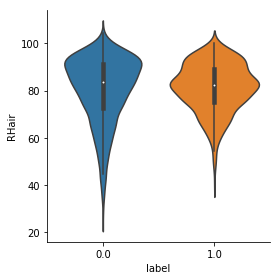

In [5]:
g = sns.factorplot(x="label", y = "RHair",data = dataset, kind="violin")

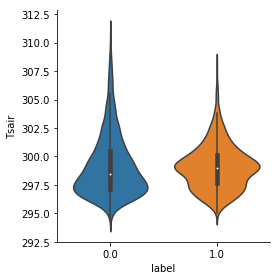

In [6]:
g = sns.factorplot(x="label", y = "Tsair",data = dataset, kind="violin")

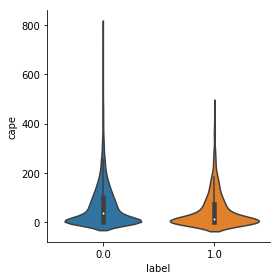

In [7]:
g = sns.factorplot(x="label", y = "cape",data = dataset, kind="violin")

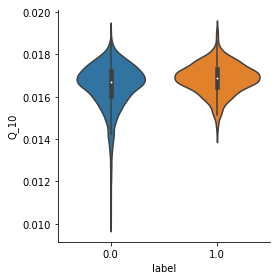

In [8]:
g = sns.factorplot(x="label", y = "Q_10",data = dataset, kind="violin")

In [9]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=10)

In [11]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
#classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7))

cv_results = []
for classifier in classifiers :
    print(classifier)
    cv_results.append(cross_val_score(classifier, trig_x_train, y = trig_y_train, scoring = "f1_macro", cv = kfold, n_jobs=4))
print(cv_results)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best')
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=2)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decreas

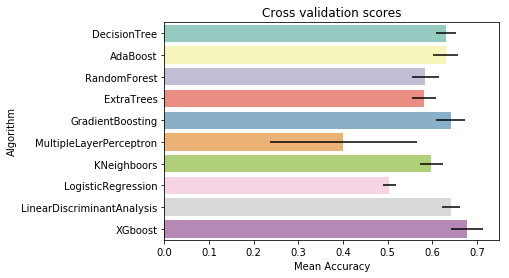

In [12]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGboost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [13]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7, n_estimators=600)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="f1_macro", n_jobs= 8, verbose = 1)

gsadaDTC.fit(trig_x_train,trig_y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 217 tasks      | elapsed:   17.8s
[Parallel(n_jobs=8)]: Done 545 out of 560 | elapsed:   35.4s remaining:    1.0s
[Parallel(n_jobs=8)]: Done 560 out of 560 | elapsed:   37.5s finished


In [16]:
print(gsadaDTC.best_score_)

0.6314123939200252


In [17]:
#ExtraTrees 
ExtC = ExtraTreesClassifier(n_estimators=600)


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsExtC.fit(trig_x_train,trig_y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_
print(ExtC_best)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   55.6s
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:  1.3min finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=10, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [18]:
# RFC Parameters tunning 
RFC = RandomForestClassifier(n_estimators=600)


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1", n_jobs= 8, verbose = 1)

gsRFC.fit(trig_x_train,trig_y_train)

RFC_best = gsRFC.best_estimator_

# Best score
print(gsRFC.best_score_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 270 out of 270 | elapsed: 10.2min finished


0.34524540852391994


In [20]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier(n_estimators=600)
gb_param_grid = {'loss' : ["deviance"],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="f1_macro", n_jobs= 8, verbose = 1)

gsGBC.fit(trig_x_train,trig_y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   42.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed:  5.1min finished


0.6959718140468552

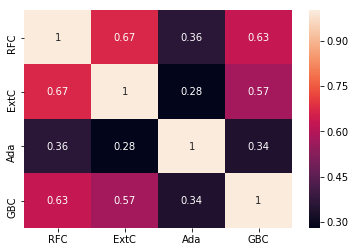

In [18]:
test_Survived_RFC = pd.Series(RFC_best.predict(trig_x_test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(trig_x_test), name="ExtC")
test_Survived_AdaC = pd.Series(ada_best.predict(trig_x_test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(trig_x_test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [26]:
xgb = XGBClassifier(n_estimators=600,silent=True, max_depth=7)
dt = DecisionTreeClassifier(random_state=random_state)
knn = KNeighborsClassifier()
ld = LinearDiscriminantAnalysis()


votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('adac',ada_best),
                                       ('gbc',GBC_best),('xgb',xgb),('dt',dt),
                                       ('knn',knn),('ld',ld)], voting='soft', n_jobs=8)

votingC = votingC.fit(trig_x_train, trig_y_train)
trig_y_prec = votingC.predict(trig_x_test)
print(f1_score(trig_y_test, trig_y_prec,average='macro'))

0.6560533748734543


## Test with the ERA-Interim and TRMM data

In [107]:
dataset_trmm = load_data.load_era_trmm()
print(dataset_trmm.shape)
print(dataset_trmm.dtypes)

(20451, 120)
t2m       float64
d2m       float64
sp        float64
cape      float64
lcl       float64
clabel    float64
t_100     float64
t_125     float64
t_150     float64
t_175     float64
t_200     float64
t_225     float64
t_250     float64
t_300     float64
t_350     float64
t_400     float64
t_450     float64
t_500     float64
t_550     float64
t_600     float64
t_650     float64
t_700     float64
t_750     float64
t_775     float64
t_800     float64
t_825     float64
t_850     float64
t_875     float64
t_900     float64
t_925     float64
           ...   
w_175     float64
w_200     float64
w_225     float64
w_250     float64
w_300     float64
w_350     float64
w_400     float64
w_450     float64
w_500     float64
w_550     float64
w_600     float64
w_650     float64
w_700     float64
w_750     float64
w_775     float64
w_800     float64
w_825     float64
w_850     float64
w_875     float64
w_900     float64
w_925     float64
w_950     float64
w_975     float64
w_1000    float

(1727, 120)
(18724, 120)


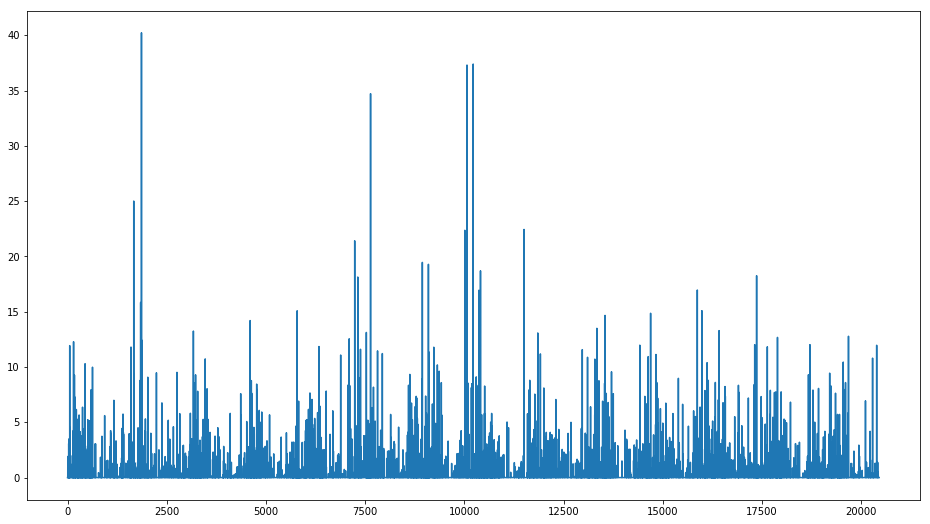

In [109]:
trig_x = dataset_trmm.iloc[:,0:114]
trig_y = dataset_trmm.iloc[:,114]
plt.figure(figsize=(16,9))
dataset_trmm['prect'].plot()

pos = dataset_trmm[dataset_trmm.label==1]
neg = dataset_trmm[dataset_trmm.label==0]
print(pos.shape)
print(neg.shape)

In [111]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7,scale_pos_weight=55.5)
f1_scores = cross_val_score(xgb, trig_x, trig_y, cv=cv, scoring="f1_macro")
print(f1_scores)

[0.63035183 0.63354869 0.65828954 0.62831603 0.64153719]


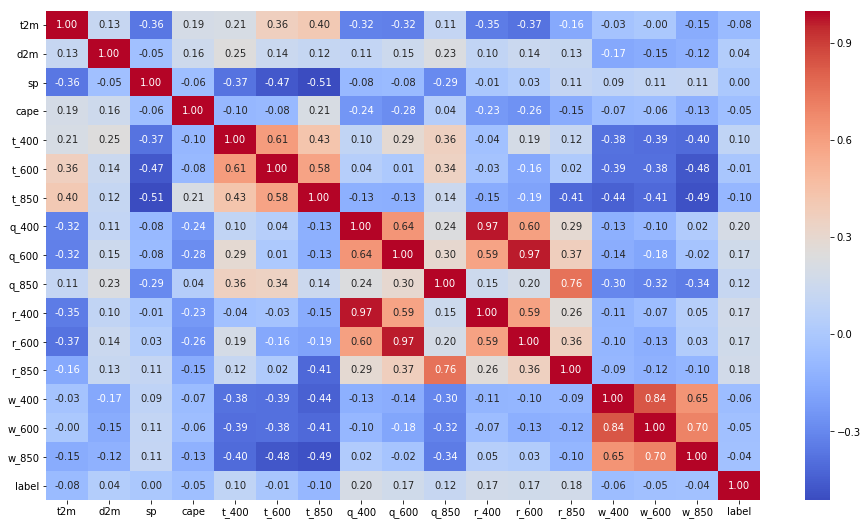

In [13]:
plt.figure(figsize=(16,9))
g = sns.heatmap(dataset[["t2m","d2m","sp","cape","t_400","t_600","t_850", "q_400","q_600", "q_850",
                         "r_400","r_600", "r_850",
                         "w_400","w_600", "w_850","label"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

## Test with ori data

In [7]:
a = load_data.load_goamazon_data()
dataset= a[a.lhflx > 400]

pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]
print(pos.shape)
print(neg.shape)

trig_x = dataset.iloc[:,0:150]
trig_y = dataset.iloc[:,150]

print(dataset.shape)
#plt.plot(trig_y)

(28, 153)
(78, 153)
(106, 153)


In [44]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
xgb = XGBClassifier(n_estimators=1000,silent=True, nthread=8, max_depth=7,scale_pos_weight=5.5)
f1_scores = cross_val_score(xgb, trig_x, trig_y, cv=cv, scoring="f1_macro")
print(f1_scores)

[0.71078393 0.74166312 0.72720766 0.72476515 0.7288567 ]


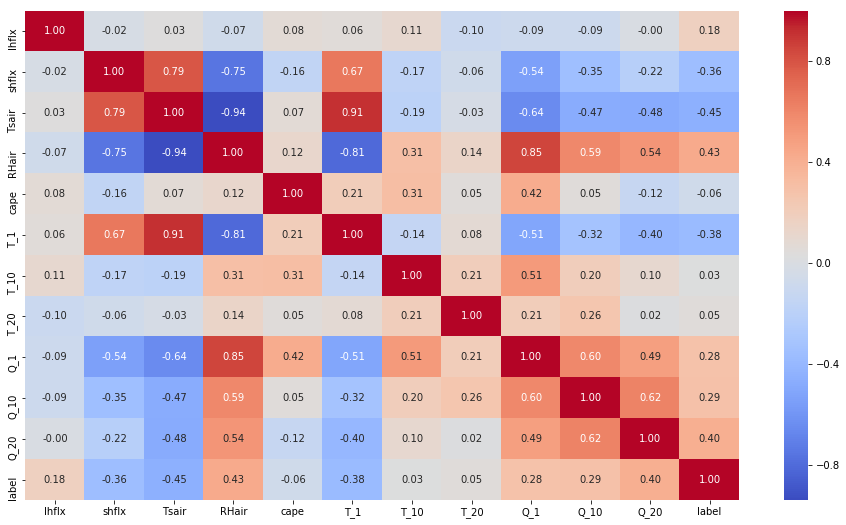

In [23]:
plt.figure(figsize=(16,9))
g = sns.heatmap(dataset[["lhflx","shflx","Tsair","RHair","cape","T_1","T_10","T_20", "Q_1","Q_10", "Q_20","label"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

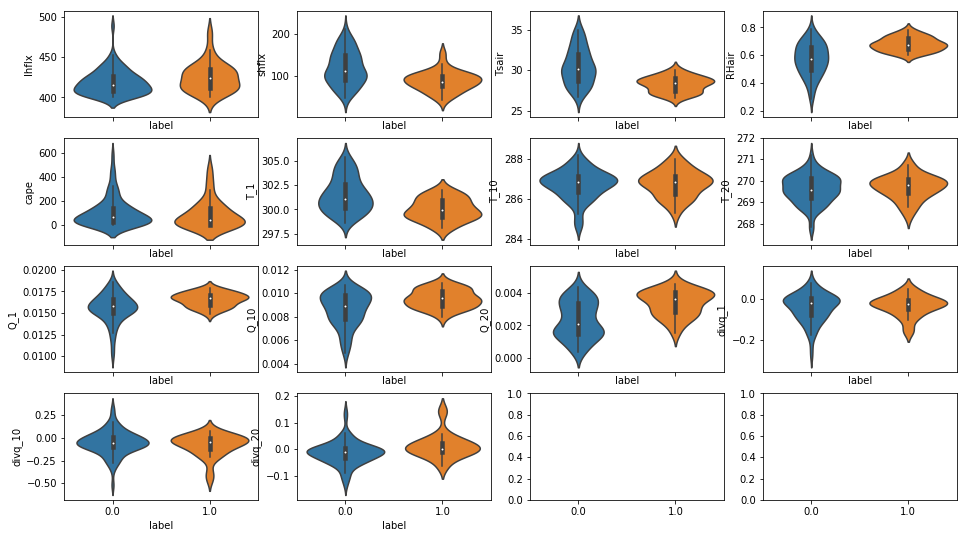

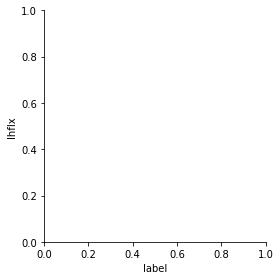

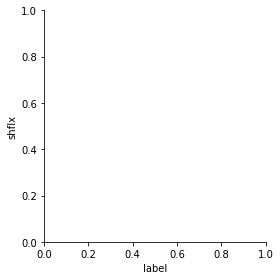

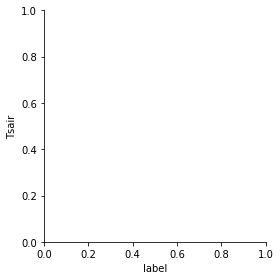

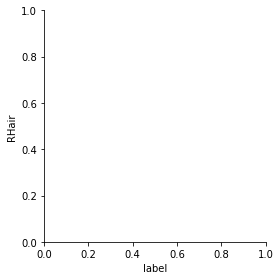

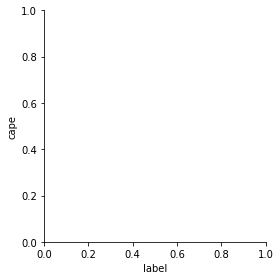

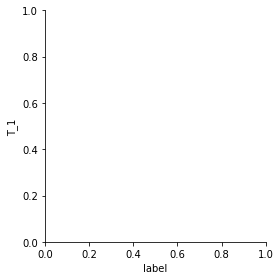

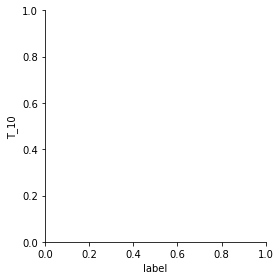

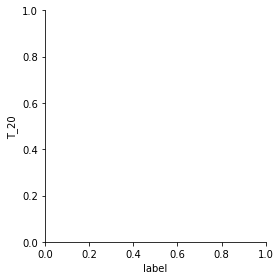

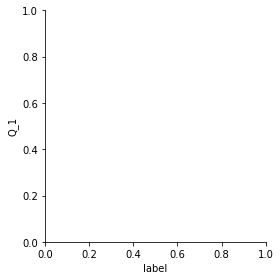

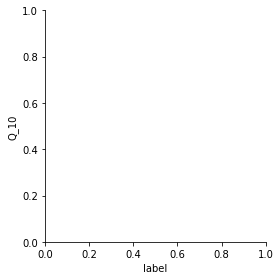

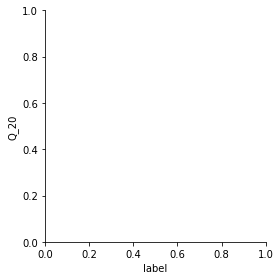

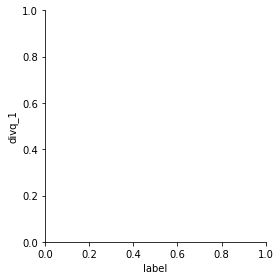

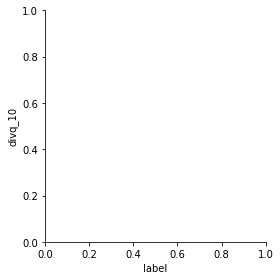

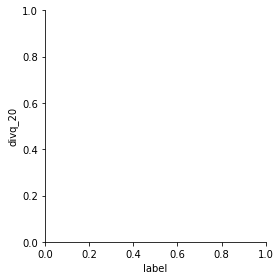

In [8]:
f, axes = plt.subplots(4, 4, figsize=(16, 9), sharex=True)
#vars_name = ["lhflx","shflx","Tsair","RHair","cape","T_1","T_10","T_20", "Q_1","Q_10", "Q_20","divq_1","divq_10", "divq_20"]
for id in range(len(vars_name)):
    g = sns.factorplot(x="label", y = vars_name[id],data = dataset, kind="violin",ax=axes[id//4, id%4])

## Test with forcing data

In [20]:
dataset = load_data.load_forcing("../../data/goamazon/GOAMAZON_iopfile_4scam.nc")
cape = np.loadtxt("/R0/wlin/Tao/CPS_trigger/data/goamazon/dilute_cape.txt")
dataset['cape'] = cape
trig_x = dataset.iloc[:,2:148]
trig_y = dataset.iloc[:,1]

In [23]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2,shuffle=False)
print(trig_x_train.shape)
print(trig_x_test.shape)

(42035, 146)
(10509, 146)


In [25]:
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7)

### cross validation

In [5]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
f1_scores = cross_val_score(xgb, trig_x, trig_y, cv=cv, scoring="f1_macro")
print(f1_scores)

[0.96487267 0.96666698 0.96726366 0.96912171 0.96844716]


### confusion repost

In [26]:
xgb.fit(trig_x_train,trig_y_train)
trig_y_pred = xgb.predict(trig_x_test)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')

print(tn,fp,fn,tp)
print(f1)

8973 23 1356 157
0.5570556182561326


In [7]:
pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]
print(pos.shape)
print(neg.shape)

(8687, 148)
(43857, 148)


### importance

In [ ]:
importance = xgb.feature_importances_
name = dataset.columns.values.tolist()
imp_df = pd.DataFrame(importance,columns=['imp'])
imp_df['name'] = name[0:86]
imp_df.set_index('name',inplace=True)
imp_df.sort_values('imp',inplace=True,ascending=False)
print(imp_df)

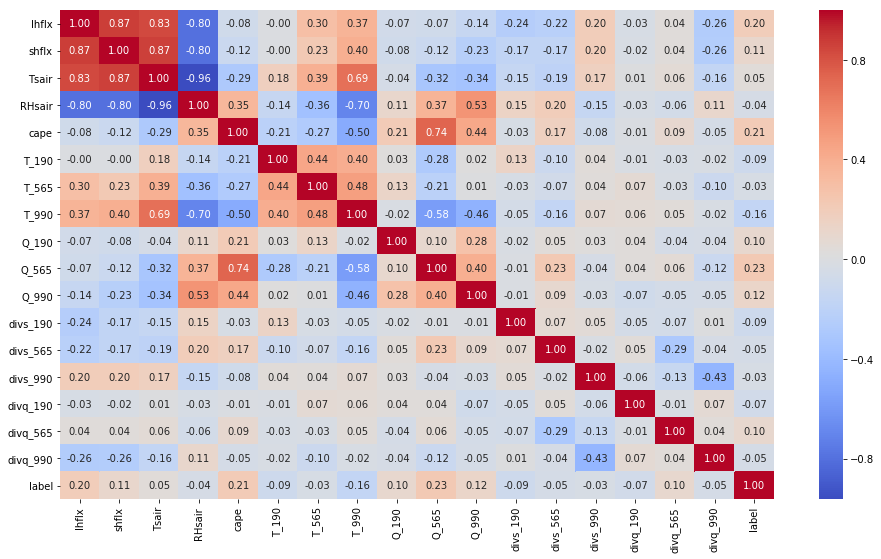

In [5]:
plt.figure(figsize=(16,9))
g = sns.heatmap(dataset[["lhflx","shflx","Tsair","RHsair",'cape',"T_190","T_565","T_990", "Q_190","Q_565", "Q_990",
                         'divs_190',"divs_565", "divs_990",'divq_190',"divq_565", "divq_990","label"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

### dilute cape performance

In [6]:
cape = trig_x_test.loc[:,'cape'].tolist()
ntime = len(cape)
dlabel = np.zeros(ntime)
for i in range(ntime):
    if cape[i] > 70: 
        dlabel[i] = 1 
    else:
        dlabel[i] = 0 

tn, fp, fn, tp = confusion_matrix(trig_y_test, dlabel).ravel()
f1 = f1_score(trig_y_test, dlabel,average='macro')

a = tp
b = fp
c = fn
d = tn  
hss  = my_metrics.hss_score(a,b,c,d)
seds = my_metrics.seds_score(a,b,c,d)
ets  = my_metrics.ets_score(a,b,c,d)

print(tn,fp,fn,tp)
print(f1)
print(hss,seds,ets)


2582 6182 106 1639
0.39679878285892756
0.09767636814277735 0.12526001013938481 0.05134582071475227


### dilute dcape performance

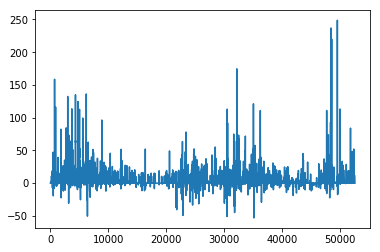

In [15]:
ddcape = np.loadtxt("/R0/wlin/Tao/CPS_trigger/data/goamazon/ddcape.txt")
dataset['cape'] = ddcape
dataset['cape'].plot()
trig_x = dataset.iloc[:,2:148]
trig_y = dataset.iloc[:,1]

In [16]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7,scale_pos_weight=3.5)
#f1_scores = cross_val_score(xgb, trig_x, trig_y, cv=cv, scoring="f1_macro")
#print(f1_scores)

/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


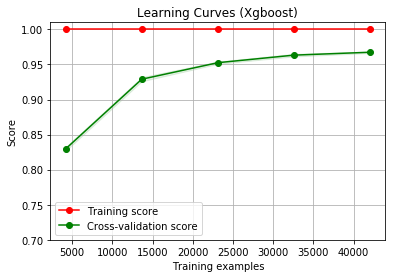

In [9]:
import plot_learning_curve
title = "Learning Curves (Xgboost)"
g = plot_learning_curve.plot_learning_curve(xgb,title,trig_x, trig_y,ylim=(0.7, 1.01), cv=cv, n_jobs=8)

In [18]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)
ddcape = trig_x_test.loc[:,'cape'].tolist()
ntime = len(ddcape)
ddlabel = np.zeros(ntime)
for i in range(ntime):
    if ddcape[i] > 0: 
        ddlabel[i] = 1 
    else:
        ddlabel[i] = 0


tn, fp, fn, tp = confusion_matrix(trig_y_test, ddlabel).ravel()
f1 = f1_score(trig_y_test, ddlabel,average='macro')

a = tp
b = fp
c = fn
d = tn  
hss  = my_metrics.hss_score(a,b,c,d)
seds = my_metrics.seds_score(a,b,c,d)
ets  = my_metrics.ets_score(a,b,c,d)

print(tn,fp,fn,tp)
print(f1)
print(hss,seds,ets)

6792 1972 820 925
0.6140208545960114
0.2412872404004029 0.2690486156627141 0.13719536580569092


In [23]:
print(len(trig_x_train))
print(len(trig_x_test))
print(sum(trig_y_train))
print(sum(trig_y_test))

42035
10509
6942.0
1745.0


### diag 

Text(0.5,1,'RHsair')

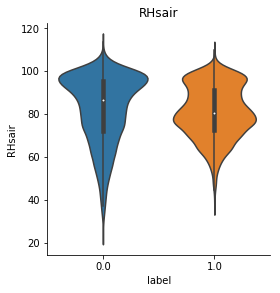

In [3]:
g = sns.factorplot(x="label", y = "RHsair",data = dataset, kind="violin")
plt.title("RHsair")

Text(0.5,1,'lhflx')

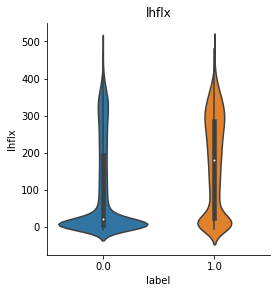

In [7]:
g = sns.factorplot(x="label", y = "lhflx",data = dataset, kind="violin")
plt.title("lhflx")

Text(0.5,1,'shflx')

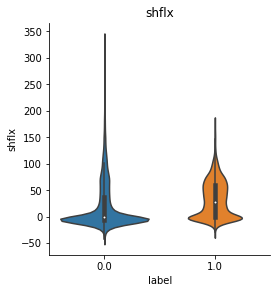

In [8]:
g = sns.factorplot(x="label", y = "shflx",data = dataset, kind="violin")
plt.title("shflx")

Text(0.5,1,'Tsair')

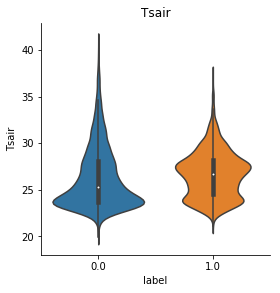

In [9]:
g = sns.factorplot(x="label", y = "Tsair",data = dataset, kind="violin")
plt.title('Tsair')

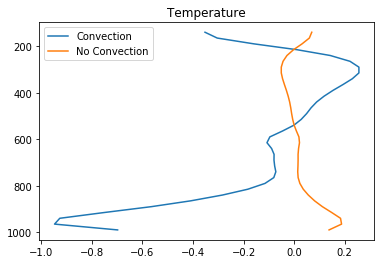

In [12]:
var_mean = dataset.mean()[8:8+35]
pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]

var_pos = pos.iloc[:,8:8+35]
var_neg = neg.iloc[:,8:8+35]

var_pos_anorm = var_pos.mean() - var_mean
var_neg_anorm = var_neg.mean() - var_mean

lev = np.loadtxt("lev_goamazon.txt")
plt.plot(var_pos_anorm, lev, label="Convection")
plt.plot(var_neg_anorm, lev, label="No Convection")
plt.gca().invert_yaxis()
plt.title("Temperature")
plt.legend()

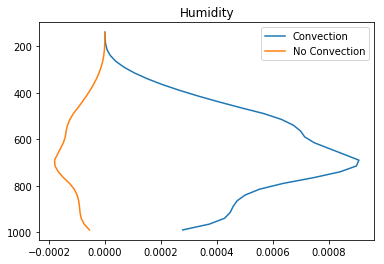

In [13]:
var_mean = dataset.mean()[43:43+35]
pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]

var_pos = pos.iloc[:,43:43+35]
var_neg = neg.iloc[:,43:43+35]

var_pos_anorm = var_pos.mean() - var_mean
var_neg_anorm = var_neg.mean() - var_mean

lev = np.loadtxt("lev_goamazon.txt")
plt.plot(var_pos_anorm, lev, label="Convection")
plt.plot(var_neg_anorm, lev, label="No Convection")
plt.gca().invert_yaxis()
plt.title("Humidity")
plt.legend()

In [ ]:
! pip install --user keras 